# Basic usage of SpinPulse

We begin by creating an ``HardwareSpecs`` instance that specifies the parameters of our spin qubit quantum computer.

In [ ]:
%load_ext autoreload
%autoreload 2
import qiskit as qi

from spin_pulse.hardware_specs import HardwareSpecs, Shape

num_qubits = 3
B_field, delta, J_coupling = 0.5, 0.2, 0.01
ramp_duration = 5
hardware_specs = HardwareSpecs(
    num_qubits, B_field, delta, J_coupling, Shape.GAUSSIAN, ramp_duration, optim=3
)

Then we specify the quantum circuit that we would like to implement and simulate. Here this is simply a CNOT on the first two qubits, while the third qubit remains at rest.

Then we specify the quantum circuit that we would like to implement and simulate. Here this is simply a CNOT on the first two qubits, while the third qubit remains at rest.

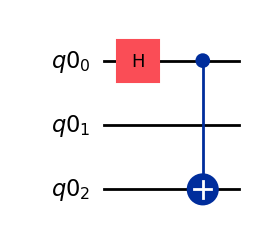

In [2]:
qreg = qi.QuantumRegister(num_qubits)
circ = qi.QuantumCircuit(qreg)

# for i in range(1, 2):
#    circ.cx(0, i)

circ.h(0)
circ.cx(0, 2)
circ.draw("mpl")

## Gate transpilation

The ``gate_transpile`` method converts our circuit to an ISA circuit that is composed of the native gates of our model. This step is realized through qiskit transpilers.

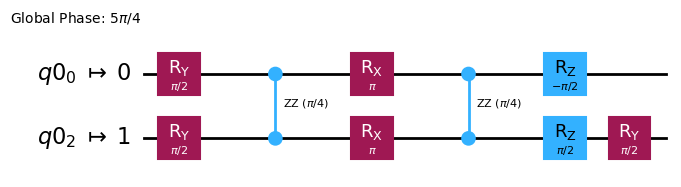

In [3]:
isa_circ = hardware_specs.gate_transpile(circ)
# isa_circ = hardware_specs.first_pass.run(circ)
isa_circ.draw("mpl", filename="output2.svg")

We obtain our transpiled circuit that is formally equivalenent to the original one, i.e they are described by the same unitary quantum channel, something that we can check using the module ``qiskit.quantum_info``, for example.

In [4]:
from qiskit.quantum_info import Operator, process_fidelity

# the transpilation process might modify the ordering between physical and logical qubits
# the function from_circuit takes into account the layout of the transpiled circuit to ensure consistent ordering
print(
    "Process fidelity between circuit and ISA circuit:",
    process_fidelity(Operator.from_circuit(circ), Operator.from_circuit(isa_circ)),
)

Process fidelity between circuit and ISA circuit: 0.9999999999999996


## Pulse transpilation

We now calculate the desired pulses parametrizing  the Hamiltonians of our spin qubit model to obtain our circuit. The class `PulseCircuit` does it based on the hardware specs, and calculates automatically the durations of each pulse that are required to achieve the different rotation gates $R_{X,Y,Z}$, $R_{ZZ}$ of our model. 

Note that in this example, some idle time is automatically included, in order to ``synchronize the qubits'' at each circuit layer. 

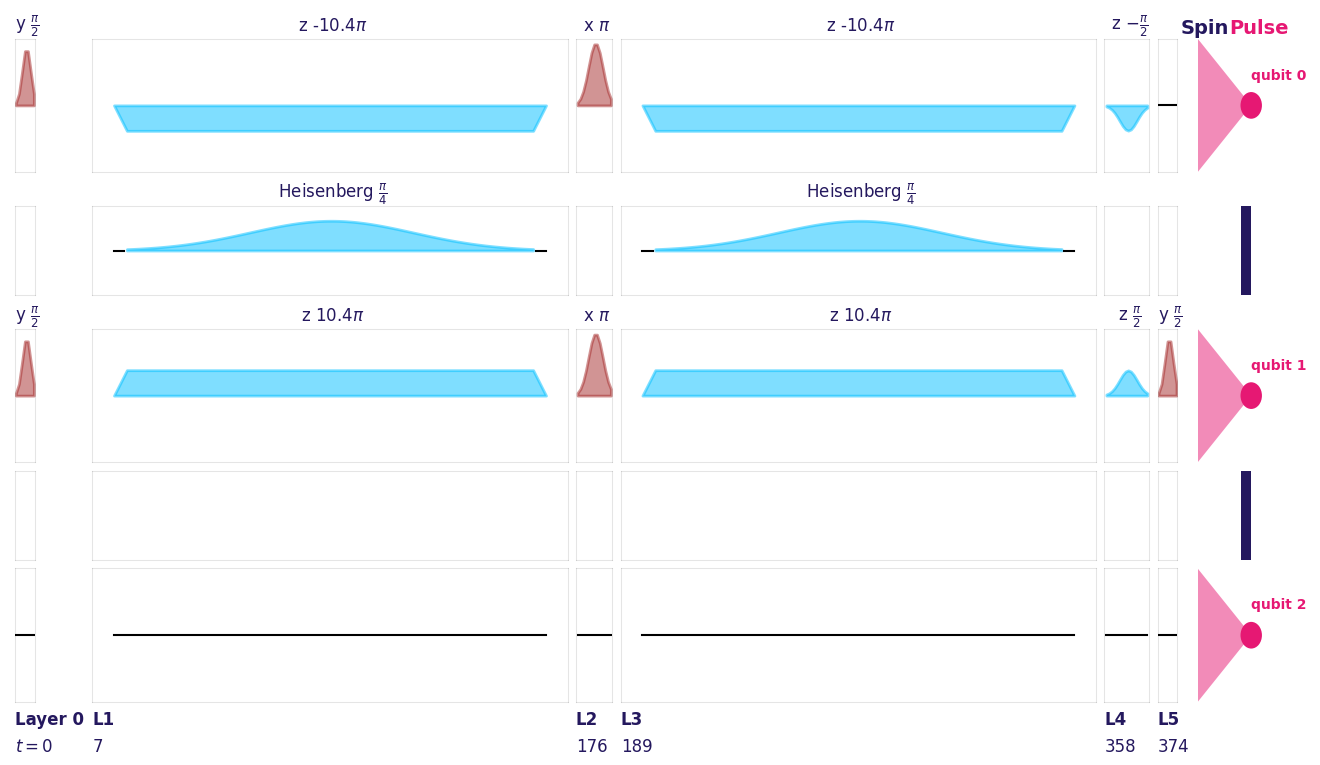

In [5]:
from spin_pulse.pulse_circuit import PulseCircuit

pulse_circuit = PulseCircuit.from_circuit(isa_circ, hardware_specs)
pulse_circuit.plot(hardware_specs=hardware_specs)

## Numerical integration

The function `to_circuit` integrates these pulses to obtain the implemented circuit as a sequence of unitary matrices representing each gate. This is the standard way to represent a quantum circuit, in particular using the class qiskit's ``QuantumCircuit`` that we use here. 

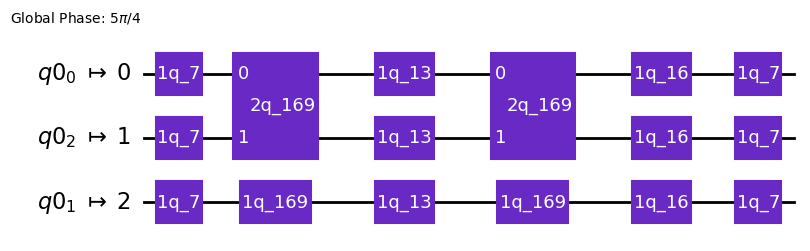

In [6]:
implemented_circ = pulse_circuit.to_circuit()
implemented_circ.draw("mpl", style="textbook", filename="output4.svg")

Having such a gate-based description allows to use qiskit functions to evaluate direclty some metrics, such as the fidelity with the original circuit.
Here the fidelity deviates from unity to the presence of small non-adiabatic contribution in the realization of the two qubit gate.

In [7]:
print(
    "Fidelity between our implemented circuit and the original circuit ",
    process_fidelity(
        Operator.from_circuit(implemented_circ), Operator.from_circuit(circ)
    ),
)

Fidelity between our implemented circuit and the original circuit  0.9999996142323203


## Noise Accurate Simulations using the ``ExperimentalEnvironment`` class

We initialize an experimental environment made of pink noise and with a coherence time $T_2=500$. 

Attaching an experimental environment in a pulse circuit leads to the presence of noisy time traces on each qubit. 

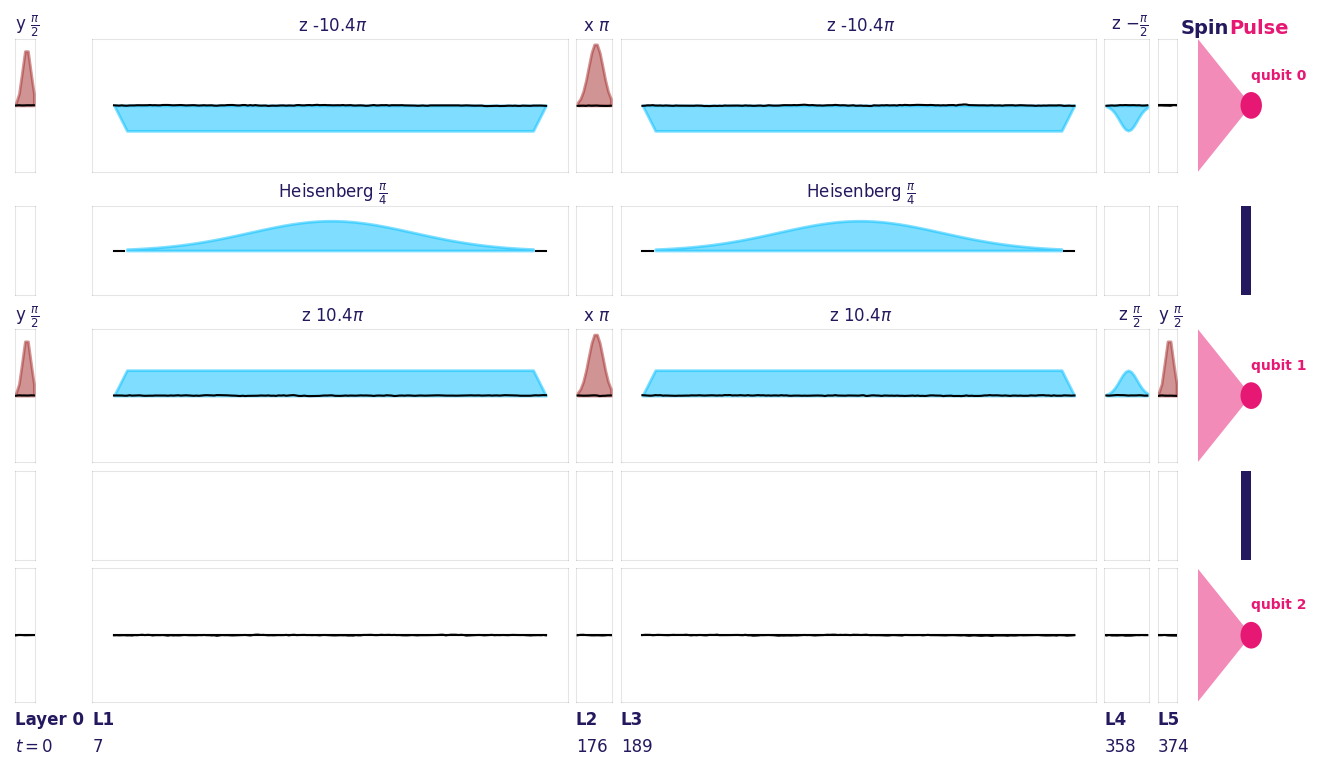

In [ ]:
from spin_pulse.experimental_environment import ExperimentalEnvironment
from spin_pulse.noise import NoiseType

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2=500,
    duration=2**15,
    segment_duration=2**15,
)
pulse_circuit_noise = PulseCircuit.from_circuit(
    isa_circ, hardware_specs, exp_env=exp_env
)
pulse_circuit_noise.plot(hardware_specs)
# import matplotlib as plt
# plt.pyplot.savefig("output3.png", dpi=600)

Averaging over different circuit executions over the duration of an experimental environment, we have access to the relevant metrics of our model, such as the mean fidelity with respect to our original circuit.

In [9]:
print("Average circuit fidelity ", pulse_circuit_noise.mean_fidelity(isa_circ, exp_env))

  0%|          | 0/86 [00:00<?, ?it/s]

100%|██████████| 86/86 [00:03<00:00, 24.00it/s]

Average circuit fidelity  0.901679403375573


## Switching to square pulses

Through a simple argument change, we can change the shapes of our pulses from Gaussian to Square, and repeat the same calculations.

Fidelity between our implemented circuit and the original circuit  0.9999557548862956


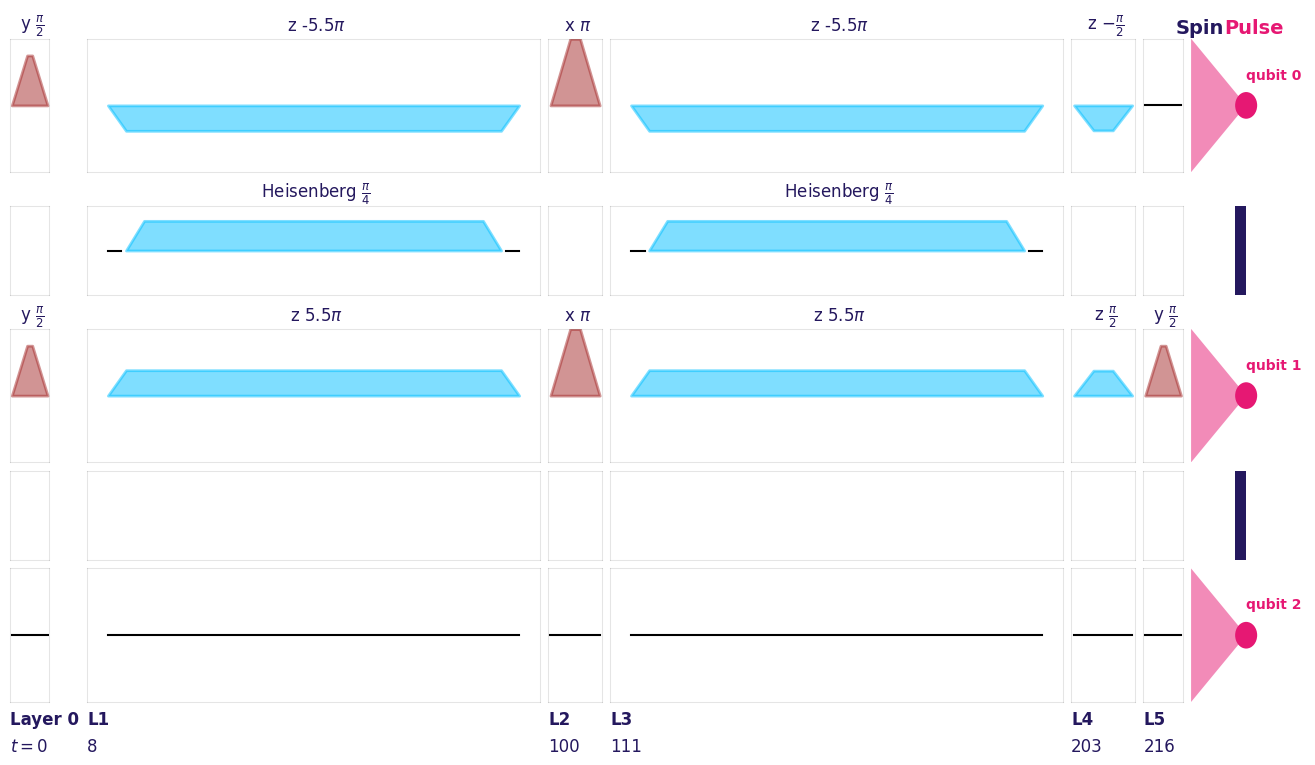

In [ ]:
ramp_duration_square = 4
hardware_specs_square = HardwareSpecs(
    num_qubits, B_field, delta, J_coupling, Shape.Square, ramp_duration_square
)
pulse_circuit_square = PulseCircuit.from_circuit(isa_circ, hardware_specs_square)
print(
    "Fidelity between our implemented circuit and the original circuit ",
    pulse_circuit_square.fidelity(isa_circ),
)
pulse_circuit_square.plot(hardware_specs)

## Dynamical decoupling

Finally, the ``dynamical_decoupling`` optional argument in the ``HardwareSpecs`` constructor allows to replace idle sequences by single qubit rotations, in order to protect the qubit from the low frequency part of the time traces  (the high-frequency part being still present and affecting coherence).

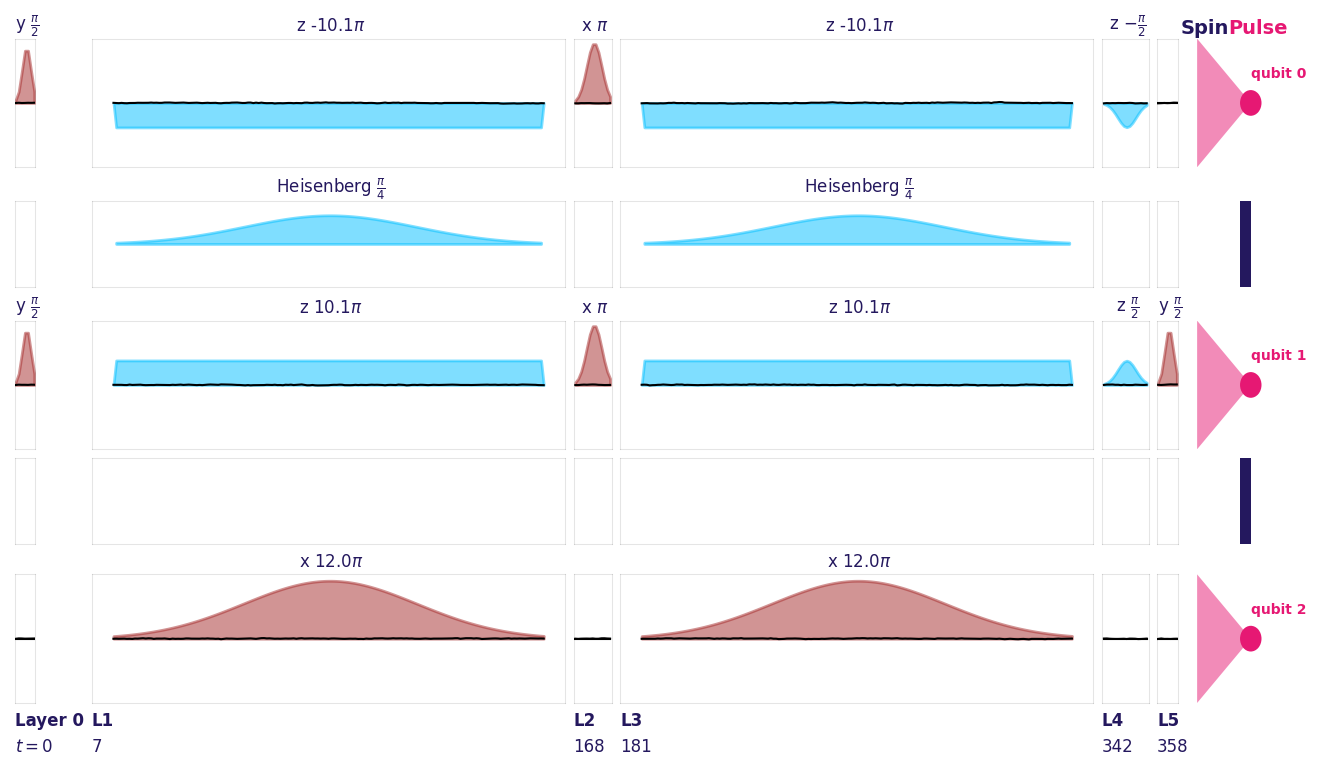

In [ ]:
hardware_specs_dd = HardwareSpecs(
    num_qubits,
    B_field,
    delta,
    J_coupling,
    Shape.GAUSSIAN,
    dynamical_decoupling="full_drive",
)
pulse_circuit_dd = PulseCircuit.from_circuit(
    isa_circ, hardware_specs_dd, exp_env=exp_env
)
pulse_circuit_dd.plot(hardware_specs)

We obtain a significant improvement

In [12]:
print(
    "Average circuit fidelity without DD:",
    pulse_circuit_noise.mean_fidelity(isa_circ, exp_env),
)
print(
    "Average circuit fidelity with DD:",
    pulse_circuit_dd.mean_fidelity(isa_circ, exp_env),
)

  0%|          | 0/86 [00:00<?, ?it/s]

100%|██████████| 86/86 [00:03<00:00, 26.92it/s]


Average circuit fidelity without DD: 0.901679403375573


100%|██████████| 89/89 [00:03<00:00, 27.41it/s]

Average circuit fidelity with DD: 0.9674673409558316
